In [1]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import graphviz
import datetime
import utils
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [2]:
def compile_data(fileNames, bearingCount):
    
    compiled_dataset = pd.DataFrame()
    
    for file in fileNames:
        fileData = pd.read_csv(file)
#         print(fileData)
        fileData['BearingNumber'] = bearingCount
#         fileData['TimeStamp'] = pd.to_datetime(fileData['Time'], unit='s')
        compiled_dataset = pd.concat([compiled_dataset, fileData])
        bearingCount+=1

    compiled_dataset['index'] = np.arange(compiled_dataset.shape[0])
    
    return compiled_dataset

In [3]:
def get_data(dataType,sensor_direction,BearingNumbers):
#     dataType = 'LEARNING'
    data_set = pd.DataFrame()
    for condition in [1,2,3]:
        for BearingNumber in BearingNumbers:
            bearing = []
            for direction in [sensor_direction]:
                if (condition ==3) & (BearingNumber >3):
                    continue
                path = 'Features/{} SET/{} acceleration Features/Features{}_{}_{}.csv'.format(dataType,
                                                                                             direction,
                                                                                             condition,
                                                                                             BearingNumber,
                                                                                             direction)

                df = pd.read_csv(path)
                df['condition'] = str(condition)
                df['BearingNumber'] = BearingNumber
                if dataType == 'LEARNING':
                    df['RUL'] = df['Time'].max() - df['Time']
                    df = df[:-1]
                data_set = pd.concat([data_set, df])
    data_set = data_set.drop(columns = 'Time')
    data_set = pd.get_dummies(data_set,columns=['condition'],drop_first=True)
    if dataType == 'LEARNING':
        data_set = data_set.drop(columns='RUL').assign(RUL = data_set.RUL)
        data_set = shuffle(data_set,random_state = 0).reset_index(drop=True)
    return data_set.set_index('BearingNumber',drop=True).drop(columns = ['SpectralKurtosisMean',
                                                                         'SpectralKurtosisStandardDeviation',
                                                       'SpectralKurtosisSkewness', 'SpectralKurtosisKurtosis',
                                                       'SpectralEntropyMean', 'SpectralEntropyStandardDeviation',
                                                       'SpectralEntropySkewness', 'SpectralEntropyKurtosis','CustomFeature3'])

In [4]:
learning_dataset_Vertical = get_data('LEARNING','Vertical',[1,2])

In [5]:
learning_dataset_Vertical.head()

,Mean,StandardDev,RMS,AbsMean,Skewness,Kurtosis,Variance,MaxValue,MinValue,Peak2Peak,...,PulseIndex,MarginIndex,SkewnessIndex,KurtosisIndex,CustomFeature1,CustomFeature2,SquareRootAmplitude,condition_2,condition_3,RUL
BearingNumber,,,,,,,,,,,,,,,,,,,,,
2,-0.002671,0.166445,0.166401,0.132348,0.076885,2.989350,0.027704,0.579421,0.000027,0.579393,...,4.377997,3.482066,16.673601,3894.878220,9.502406,0.166358,0.111617,1,0,7360
2,-0.002230,0.106731,0.106712,0.083711,0.028313,3.317644,0.011391,0.389178,0.000002,0.389176,...,4.649041,3.646978,23.287272,25566.422917,15.230711,0.106694,0.070305,0,1,590
2,-0.018287,0.248625,0.249200,0.161706,0.034010,8.584262,0.061814,1.285793,0.000039,1.285754,...,7.951435,5.159687,2.212925,2246.590664,9.508104,0.249776,0.123478,1,0,500
1,-0.022546,0.079770,0.082865,0.066251,0.025062,2.978763,0.006363,0.283905,0.000030,0.283875,...,4.285291,3.426104,49.373476,73565.432394,18.174193,0.086080,0.056246,1,0,2730
1,0.003728,0.190570,0.190532,0.151422,-0.023699,2.974831,0.036317,0.601967,0.000132,0.601835,...,3.975426,3.159407,-3.424285,2255.529070,8.311432,0.190494,0.127881,0,0,27300


In [6]:
learning_dataset_Vertical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7528 entries, 2 to 1
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mean                 7528 non-null   float64
 1   StandardDev          7528 non-null   float64
 2   RMS                  7528 non-null   float64
 3   AbsMean              7528 non-null   float64
 4   Skewness             7528 non-null   float64
 5   Kurtosis             7528 non-null   float64
 6   Variance             7528 non-null   float64
 7   MaxValue             7528 non-null   float64
 8   MinValue             7528 non-null   float64
 9   Peak2Peak            7528 non-null   float64
 10  WaveformIndex        7528 non-null   float64
 11  PeakIndex            7528 non-null   float64
 12  PulseIndex           7528 non-null   float64
 13  MarginIndex          7528 non-null   float64
 14  SkewnessIndex        7528 non-null   float64
 15  KurtosisIndex        7528 non-null   floa

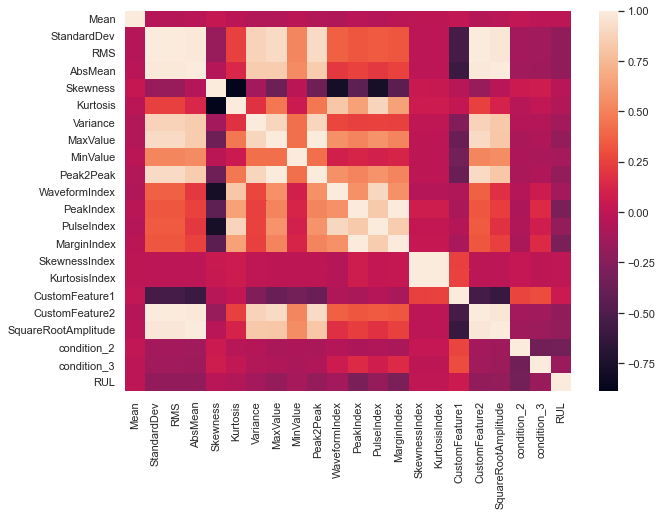

In [7]:
import seaborn as sns
plt.figure(figsize=(10,7))
correlation_matrix = learning_dataset_Vertical.corr()
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns)

In [8]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))
# print(upper_tri)

In [9]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop

['RMS',
 'AbsMean',
 'Peak2Peak',
 'MarginIndex',
 'KurtosisIndex',
 'CustomFeature2',
 'SquareRootAmplitude']

In [10]:
learning_dataset_Vertical = learning_dataset_Vertical.drop(columns = to_drop)

## Machine Learning Model
Before we use that feature matrix to make predictions, we should check how well guessing does on this dataset. We can use a `train_test_split` from scikit-learn to split our training data once and for all.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [12]:
X = learning_dataset_Vertical.drop(columns='RUL').values
y = learning_dataset_Vertical['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17,train_size=0.8)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Applying Kernal PCA

In [14]:
from sklearn.decomposition import PCA

transformer = PCA(n_components=5)
X_train =transformer.fit_transform(X_train)

In [15]:
np.cumsum(transformer.explained_variance_ratio_)

array([0.35419863, 0.54461316, 0.64199131, 0.7305649 , 0.80182377])

# Step 3: Using the Model
Now, we can use our created features to fit a `RandomForestRegressor` to our data and see if we can improve on the previous scores.

In [16]:
X_train.shape

(6022, 5)

In [17]:
reg = RandomForestRegressor(n_estimators=18,random_state=13)
reg.fit(X_train, y_train)

preds = reg.predict(transformer.transform(scaler.transform(X_test)))
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))

# high_imp_feats = utils.feature_importances(X, reg, feats=10)

Mean Abs Error: 2462.73


In [18]:
reg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=18, n_jobs=None, oob_score=False,
                      random_state=13, verbose=0, warm_start=False)

## Test set

In [19]:
#getting the data from files
Test_dataset_Vertical = get_data('TEST','Vertical',[3,4,5,6,7])

In [20]:
Test_dataset_Vertical.head()

,Mean,StandardDev,RMS,AbsMean,Skewness,Kurtosis,Variance,MaxValue,MinValue,Peak2Peak,...,PeakIndex,PulseIndex,MarginIndex,SkewnessIndex,KurtosisIndex,CustomFeature1,CustomFeature2,SquareRootAmplitude,condition_2,condition_3
BearingNumber,,,,,,,,,,,,,,,,,,,,,
3,0.014267,0.081451,0.082660,0.064986,0.276928,3.205986,0.006634,0.324098,0.000018,0.324080,...,3.979052,4.987233,3.920865,512.481179,72840.938816,19.286948,0.083887,0.054658,0,0
3,0.005227,0.075278,0.075430,0.059600,0.114823,3.380948,0.005667,0.274640,0.000004,0.274636,...,3.648332,4.608076,3.640984,269.167835,105284.064458,21.192478,0.075582,0.050415,0,0
3,-0.015779,0.076756,0.078331,0.061699,0.144595,3.267382,0.005891,0.287763,0.000077,0.287686,...,3.749067,4.663964,3.673651,319.756261,94135.966535,20.162892,0.079940,0.051626,0,0
3,-0.011277,0.078014,0.078794,0.062700,0.107867,3.045621,0.006086,0.248614,0.000058,0.248556,...,3.186793,3.965136,3.155219,227.181894,82222.486985,19.844359,0.079583,0.053177,0,0
3,-0.016224,0.074611,0.076326,0.061894,0.180571,2.892517,0.005567,0.235779,0.000084,0.235695,...,3.160106,3.809423,3.089095,434.749839,93338.997404,19.476536,0.078081,0.053105,0,0


In [21]:
Test_dataset_Vertical = Test_dataset_Vertical.drop(columns = to_drop)

In [22]:
#predict RUL for every record
Test_dataset_Vertical['predicted_RUL'] = reg.predict(transformer.transform(scaler.transform(Test_dataset_Vertical)))
Test_dataset_Vertical['predicted_RUL'].head()

BearingNumber
3     9303.333333
3     8221.111111
3     9093.333333
3     9899.444444
3    10576.111111
Name: predicted_RUL, dtype: float64

In [23]:
#reset condition
Test_dataset_Vertical.loc[(Test_dataset_Vertical.condition_2 == 0)&
                           (Test_dataset_Vertical.condition_3 == 0),'condition'] = '1'
Test_dataset_Vertical.loc[(Test_dataset_Vertical.condition_2 == 1)&
                           (Test_dataset_Vertical.condition_3 == 0),'condition'] = '2'
Test_dataset_Vertical.loc[(Test_dataset_Vertical.condition_2 == 0)&
                           (Test_dataset_Vertical.condition_3 == 1),'condition'] = '3'

In [24]:
#get the RUL for each bearing number as minium value
Test_dataset_Vertical.reset_index().groupby(['BearingNumber','condition'],as_index = False,sort=False)['predicted_RUL'].min()

,BearingNumber,condition,predicted_RUL
0,3,1,34.444444
1,4,1,45.000000
2,5,1,1525.555556
3,6,1,1217.777778
4,7,1,1411.666667
5,3,2,215.000000
6,4,2,211.111111
7,5,2,1242.222222
8,6,2,2335.000000
9,7,2,520.000000


In [25]:
#get the RUL for each bearing number as last value
result = Test_dataset_Vertical.reset_index().groupby(['BearingNumber','condition'],as_index = False,sort=False)['predicted_RUL'].quantile(0)

In [26]:
result['RUL'] = [5730,339 ,1610 ,1460,7570 ,7530 ,1390,3090 ,1290, 580,820]

result['%ERi'] = 100 * (result['RUL']  - result['predicted_RUL'] ) /result['RUL']

In [27]:
def cal_score(value):
    if value < 0:
        Ai = np.exp(-np.log(0.5)*(value/5))
    else:
        Ai = np.exp(np.log(0.5)*(value/20))
    return Ai

## Score

In [28]:
round(result['%ERi'].map(cal_score).mean(),4)

0.2227

In [29]:
print(result)

    BearingNumber condition  predicted_RUL   RUL        %ERi
0               3         1      34.444444  5730   99.398875
1               4         1      45.000000   339   86.725664
2               5         1    1525.555556  1610    5.244997
3               6         1    1217.777778  1460   16.590563
4               7         1    1411.666667  7570   81.351827
5               3         2     215.000000  7530   97.144754
6               4         2     211.111111  1390   84.812150
7               5         2    1242.222222  3090   59.798634
8               6         2    2335.000000  1290  -81.007752
9               7         2     520.000000   580   10.344828
10              3         3    1765.555556   820 -115.311653


In [ ]:
x = np.array(["1_3", "1_4", "1_5", "1_6", "1_7"
              , "2_3", "2_4", "2_5", "2_6", "2_7"
              , "3_3"])
y = [ 34, 45, 1525, 1217, 1411, 215, 211, 1242, 2335, 520, 1765]


  
# plt.scatter(x, y, Label="Predicted RUL")
# plt.scatter(x, result['RUL'], Label="Actual RUL")


fig, ax = plt.subplots()
ax.scatter(x, y, label="Predicted RUL")
ax.scatter(x, result['RUL'], label="Actual RUL")
ax.legend()

plt.xlabel("Bearings")
plt.ylabel("RUL")
plt.title("Remaining Useful Life of Bearings")

plt.show()